In [1]:
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_dcm_bbox(dcm_path, bbox_df):
    """
    dcm : path to dicom file
    bbox: df containing bbox information
    channel: 'copy' or 'pad'
    """
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array 
    
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate((img, img, img), axis=2)
        # Or just use: img = np.stack((img,) * 3, axis=-1)
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)
    ax.imshow(img, cmap=None)
    for ix, row in bbox_df.iterrows():
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        bbox = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(bbox)
    plt.show()

In [2]:
dfl = pd.read_csv('stage_1_train_labels.csv')
dfl[dfl['Target'] == 1].head(5)

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


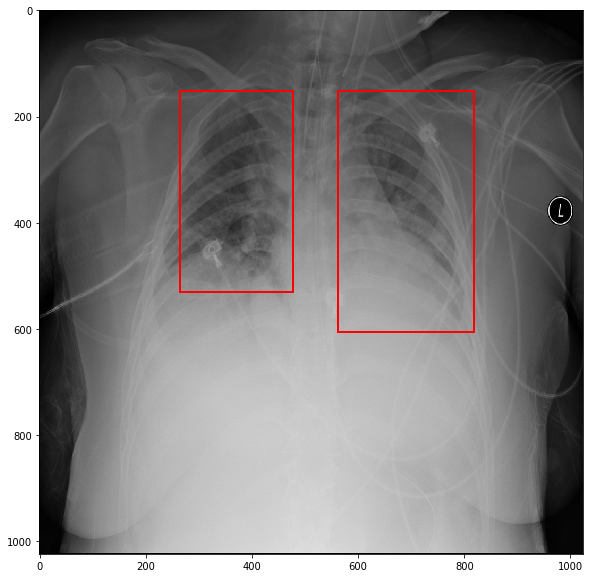

In [3]:
path = '/home/ankoor/kaggle-data/stage_1_train_images/'
pid = '00436515-870c-4b36-a041-de91049b9ab4'

dcm_path = path + pid + '.dcm'
bbox_df = pd.DataFrame(dfl.query('patientId == "{}"'.format(pid)))

plot_dcm_bbox(dcm_path, bbox_df)

# Augmentations

**[Reference: Data Augmentation For Object Detection](https://github.com/Paperspace/DataAugmentationForObjectDetection)**

### Helper Functions

In [4]:
import cv2
import random
import numpy as np

def draw_box(img, coords):
    """
    Function to draw bounding boxes on image.
    """
    img = img.copy()
    coords = coords.reshape(-1, 4)
    for coord in coords:
        ul_pt = (int(coord[0]), int(coord[1]))  # Upper left point
        br_pt = (int(coord[2]), int(coord[3]))  # Bottom right point
        color = [255, 0, 0]        
        img = cv2.rectangle(img.copy(), ul_pt, br_pt, color, 
                            int(max(img.shape[:2])/200))
    return img

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])
        
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image.
    
    bbox: numpy.ndarray. Numpy array containing bounding boxes of shape N X 4 where N is the 
        number of bounding boxes and the bounding boxes are represented in the format x1 y1 x2 y2
    
    clip_box: numpy.ndarray. An array of shape (4,) specifying the diagonal co-ordinates of the image.
        The coordinates are represented in the format x1 y1 x2 y2
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is less than alpha the 
        bounding box is dropped.     
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]

    return bbox

def rotate_img(image, angle):
    """
    Rotate the image. Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored black. 
    
    image : numpy.ndarray. Numpy image

    angle : float. Angle by which the image is to be rotated
    """
    # Grab the dimensions of the image and then determine the centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # Grab the rotation matrix (applying the negative of the angle to rotate clockwise), then grab 
    # the sine and cosine (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # Compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    return image

def get_corners(bboxes):
    """
    Get corners of bounding boxes
    
    bboxes: numpy.ndarray. Numpy array containing bounding boxes of shape N X 4 where N is the 
        number of bounding boxes and the bounding boxes are represented in the format x1 y1 x2 y2
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    corners : numpy.ndarray. Numpy array of shape N x 8 containing N bounding boxes each described 
        by their corner co-ordinates x1 y1 x2 y2 x3 y3 x4 y4
    
    angle : float. Angle by which the image is to be rotated
        
    cx : int. x coordinate of the center of image (about which the box will be rotated)
        
    cy : int. y coordinate of the center of image (about which the box will be rotated)
        
    h : int. Height of the image
        
    w : int. Width of the image
    """
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

def create_enclosing_box(corners):
    """
    Create an enclosing box for rotated corners of a bounding box
    
    corners : numpy.ndarray. Numpy array of shape N x 8 containing N bounding boxes each described 
        by their corner co-ordinates x1 y1 x2 y2 x3 y3 x4 y4  
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

## 1. Horizontal Flip

In [5]:
class RandomHorizontalFlip(object):
    """
    Randomly horizontally flips the Image with the probability p
    
    p: float. The probability with which the image is flipped
    """
    def __init__(self, p=1):
        self.p = p

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.p:
            img = img[:, ::-1, :]
            bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

            box_w = abs(bboxes[:, 0] - bboxes[:, 2])

            bboxes[:, 0] -= box_w
            bboxes[:, 2] += box_w

        return img, bboxes

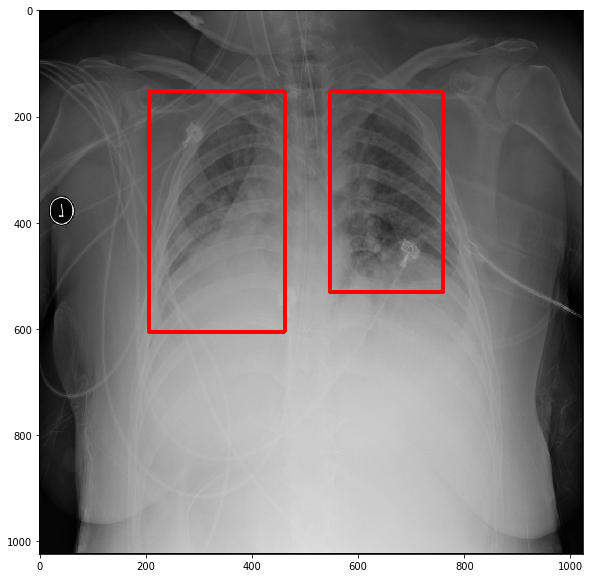

In [6]:
# Horizontal Flip Test

img = pydicom.dcmread(dcm_path).pixel_array
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)
    
# Raw bounding boxes
bboxes = bbox_df[['x', 'y', 'width', 'height']].values

# Convert W and H to x2 and y2
bboxes[:, [2, 3]] += bboxes[:, [0, 1]]

# Horizontal Flip
h_flip = RandomHorizontalFlip(0.5)
h_img, h_bboxes = h_flip(img, bboxes)
img_bb = draw_box(h_img, h_bboxes)
plt.figure(figsize=(10,10))
plt.imshow(img_bb)

## 2 Scale

In [7]:
class RandomScale(object):
    """
    Randomly scales an image. Bounding boxes which have an area of less than 25% 
    in the remaining in the transformed image is dropped. The resolution is maintained, 
    and the remaining area if any is filled by black color.

    scale: float or tuple(float). If float, the image is scaled by a factor drawn 
        randomly from a range (1 - scale , 1 + scale). If tuple, the scale is drawn 
        randomly from values specified by the tuple        
    """
    def __init__(self, scale=0.2, diff=False):
        self.scale = scale
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "Invalid range"
            assert self.scale[0] > -1, "Scale factor can't be less than -1"
            assert self.scale[1] > -1, "Scale factor can't be less than -1"
        else:
            assert self.scale > 0, "Please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff

    def __call__(self, img, bboxes):
    
        img_shape = img.shape
        
        # Chose a random digit to scale by 
        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x
        
        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y
        
        img=  cv2.resize(img, None, fx=resize_scale_x, fy=resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)
    
        return img, bboxes

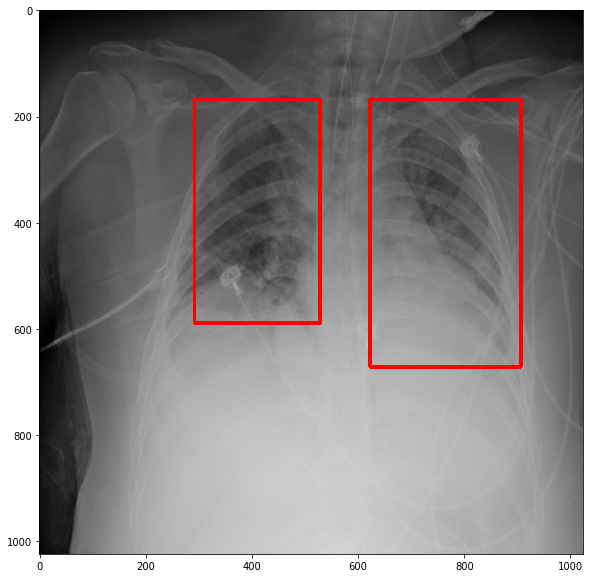

In [8]:
# Scale Test

img = pydicom.dcmread(dcm_path).pixel_array
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)
    
# Raw bounding boxes
bboxes = bbox_df[['x', 'y', 'width', 'height']].values

# Convert W and H to x2 and y2
bboxes[:, [2, 3]] += bboxes[:, [0, 1]]

# Scale
scale = RandomScale()
s_img, s_bboxes = scale(img, bboxes)
img_bb = draw_box(s_img, s_bboxes)
plt.figure(figsize=(10,10))
plt.imshow(img_bb)

## 3 Translate 

In [9]:
class RandomTranslate(object):
    """
    Randomly Translates the image. Bounding boxes which have an area of less than 25% in the 
    remaining in the transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.

    translate: float or tuple(float). If float, the image is translated by a factor drawn randomly 
        from a range (1 - translate , 1 + translate). If tuple, translate is drawn randomly from values 
        specified by the tuple
    """

    def __init__(self, translate=0.2, diff=False):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1
        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)
            
        self.diff = diff

    def __call__(self, img, bboxes):        
        
        img_shape = img.shape
        
        # Translate the image
        # Percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(img_shape).astype(np.uint8)
        
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        # Change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), 
                           min(img_shape[1],corner_x + img.shape[1])]
    
        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), 
                   max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        
        return img, bboxes

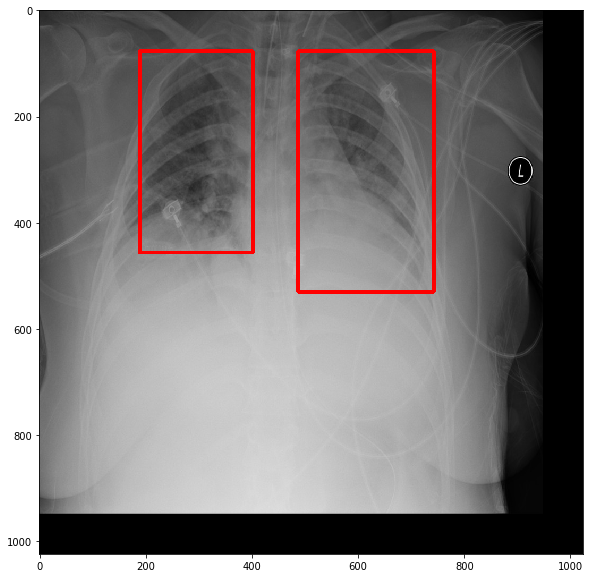

In [10]:
# Translate Test

img = pydicom.dcmread(dcm_path).pixel_array
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)
    
# Raw bounding boxes
bboxes = bbox_df[['x', 'y', 'width', 'height']].values

# Convert W and H to x2 and y2
bboxes[:, [2, 3]] += bboxes[:, [0, 1]]

# Translate
translate = RandomTranslate()
t_img, t_bboxes = translate(img, bboxes)
img_bb = draw_box(t_img, t_bboxes)
plt.figure(figsize=(10,10))
plt.imshow(img_bb)

## 4 Rotate

In [11]:
class RandomRotate(object):
    """
    Randomly rotates an image. Bounding boxes which have an area of less than 25% in the remaining 
    in the transformed image is dropped. The resolution is maintained, and the remaining area if any 
    is filled by black color.
    
    angle: float or tuple(float). If float, the image is rotated by a factor drawn randomly from a 
        range (-angle, angle). If tuple, the angle is drawn randomly from values specified by the tuple
    """
    def __init__(self, angle=10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"  
        else:
            self.angle = (-self.angle, self.angle)
            
    def __call__(self, img, bboxes):
    
        angle = random.uniform(*self.angle)
    
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
    
        img = rotate_img(img, angle)
    
        corners = get_corners(bboxes)
    
        corners = np.hstack((corners, bboxes[:,4:]))
    
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = create_enclosing_box(corners)
    
        scale_factor_x = img.shape[1] / w
    
        scale_factor_y = img.shape[0] / h
    
        img = cv2.resize(img, (w,h))
    
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes  = new_bbox
    
        bboxes = clip_box(bboxes, [0,0,w,h], 0.25)
    
        return img, bboxes

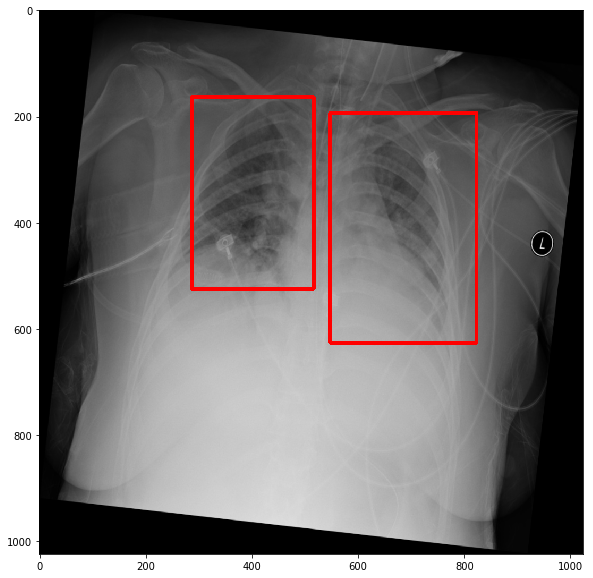

In [12]:
# Rotate Test

img = pydicom.dcmread(dcm_path).pixel_array
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)
    
# Raw bounding boxes
bboxes = bbox_df[['x', 'y', 'width', 'height']].values

# Convert W and H to x2 and y2
bboxes[:, [2, 3]] += bboxes[:, [0, 1]]

# Rotate
rotate = RandomRotate()
r_img, r_bboxes = rotate(img, bboxes)
img_bb = draw_box(r_img, r_bboxes)
plt.figure(figsize=(10,10))
plt.imshow(img_bb)

## 5 Shear

In [13]:
class RandomShear(object):
    """
    Randomly shears an image in horizontal direction. Bounding boxes which have an area of less 
    than 25% in the remaining in the transformed image is dropped. The resolution is maintained, 
    and the remaining area if any is filled by black color.

    shear_factor: float or tuple(float). If float, the image is sheared horizontally by a factor 
        drawn randomly from a range (-shear_factor, shear_factor). If tuple, the shear_factor is 
        drawn randomly from values specified by the tuple
    """
    def __init__(self, shear_factor=0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
    def __call__(self, img, bboxes):
    
        shear_factor = random.uniform(*self.shear_factor)
    
        w,h = img.shape[1], img.shape[0]
    
        if shear_factor < 0:
            img, bboxes = RandomHorizontalFlip(p=1)(img, bboxes)
    
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
    
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
    
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * abs(shear_factor) ).astype(int) 
    
        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
    
        if shear_factor < 0:
            img, bboxes = RandomHorizontalFlip(p=1)(img, bboxes)
    
        img = cv2.resize(img, (w,h))
    
        scale_factor_x = nW / w
    
        bboxes[:,:4] /= [scale_factor_x, 1, scale_factor_x, 1] 
        
        return img, bboxes

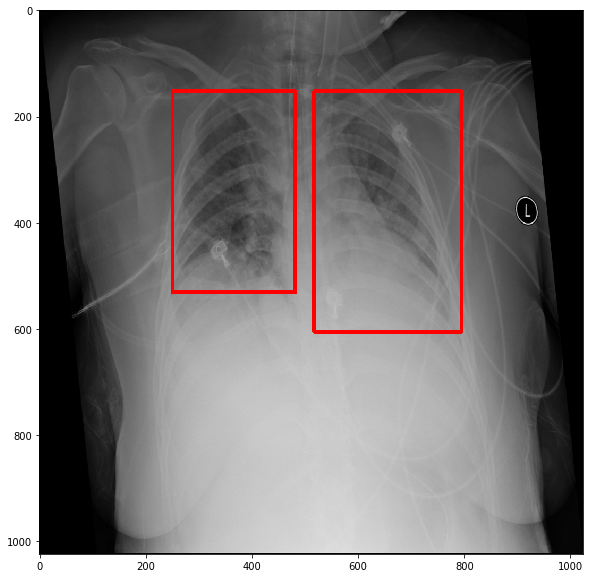

In [14]:
# Shear Test

img = pydicom.dcmread(dcm_path).pixel_array
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)
    
# Raw bounding boxes
bboxes = bbox_df[['x', 'y', 'width', 'height']].values

# Convert W and H to x2 and y2
bboxes[:, [2, 3]] += bboxes[:, [0, 1]]

# Shear
shear = RandomShear()
s_img, s_bboxes = shear(img, bboxes)
img_bb = draw_box(s_img, s_bboxes)
plt.figure(figsize=(10,10))
plt.imshow(img_bb)